<a href="https://colab.research.google.com/github/c3qian/Hello-Chao/blob/master/OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Recurrent Neural Network (CRNN) for OCR


Steps for OCR:

1. Preprocessing Data
2. Creating Network Architecture(CTC loss function)
3. Training Model
4. Test Model

###Import

In [0]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

#ignore warnings in the output
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

from glob import glob
 
import matplotlib.pyplot as plt 

### Preprocessing

1. Download and unzip the dataset into a folder
2. Preprocess the data: both inputs and outputs

Input:

*   Read the images and convert them into gray-scale images(why?)
*   Reshape each image to size (128,32) (why?)
*   Expand the dimension of the image from (128,32) to (128,32,1) (why?)
*   Normalize the image pixel values by dividing it with 255

Output:

*   Read the image file names as the labels of that image
*   Encode word into digits using a map (‘a’:0, ‘b’:1 …….. ‘z’:26 ......) e.g.  "aabb" -> [0,0,1,1]
*   Find the maximum length among all words and pad every label to be the same size(max size) 



In [0]:
!wget https://transfer.sh/ZHMV4/dataset.zip
!unzip dataset.zip


In [0]:
path = 'dataset/'
 
#lists for training dataset
train_x = []
train_y = []
train_x_len = []
train_y_len = []
orig_y = []
 
#lists for validation dataset
val_x = []
val_y = []
val_x_len = []
val_y_len = []
val_orig_y = []
 
max_label_len = 0
 
flag = 0
 
for i, f_name in enumerate(glob(os.path.join(path,'*/*.jpg'))):
    # read input image and convert into gray scale image
    img = ?

    # convert each image of shape (32, 128, 1)
    # hint: cv2.resize, np.expand_dims
    img = ?

    # Normalize each image
    img = ?

    # get the text from the image
    txt = os.path.basename(f_name).split('_')[1]

    # compute maximum length of the text
    if len(txt) > max_label_len:
        max_label_len = len(txt)


    # split the data into validation and training dataset as 1:9
    if ?:     
        val_x.append(img)
        val_y.append(encode_to_labels(txt))
        val_x_len.append(31)
        val_y_len.append(len(txt))
        val_orig_y.append(txt)  
    else:
        train_x.append(img)
        train_y.append(encode_to_labels(txt)) 
        train_x_len.append(31)
        train_y_len.append(len(txt))
        orig_y.append(txt)


number of training data: 2881
number of validation data: 320
Label value:  [38, 0, 17, 0, 1, 14, 20, 19]
Raw Label value:  Marabout


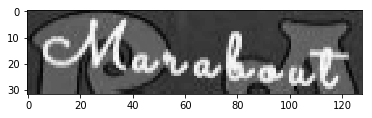

In [0]:
# Check your preprocessing results
print('Number of training data:',len(train_x))
print('Number of validation data:',len(val_x))

plt.imshow(train_x[0][:,:,0], cmap='gray')
print('Label value: ',train_y[0])
print('Raw Label value: ', orig_y[0])

In [0]:
# char_list:   'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
char_list = string.ascii_letters+string.digits
print('char_list:',char_list)
print('total length:', len(char_list))
 
# every word is encoded as a list of digits
# the digit for each character is represented by the index
# e.g. aabb -> [0,0,1,1], index of a is 0, index of b is 1

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    ?
    return dig_lst
  
# pad each output label to maximum text length
# use "post" padding
# this is not zero padding, we want to pad a specific value: len(char_list)
 
train_padded_y = pad_sequences(?)
val_padded_y = pad_sequences(?)

char_list: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
total length: 62


### Network Archtecture

Paper link: (https://arxiv.org/pdf/1507.05717.pdf)

1. Input shape (32,128,1)
2. Use CNN to produce feature map
5. Make feature map compatible with LSTM layer.
6. Use two Bidirectional LSTM layers each of which has 128 units. 

In [0]:
# input with shape of height=32 and width=128 
inputs = Input(?)
 
# Conv2D: 64 filters, (3,3) kernels, rectified unit, use "same" padding
# Pooling: (2,2) size, stride 2
conv_1 = ?
pool_1 = ?
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer, 
# blog: https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
# reduce the dimension
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
# we want to return sequences, not the last output
# use dropout 0.2
blstm_1 = Bidirectional(LSTM(?))(squeezed)
blstm_2 = Bidirectional(LSTM(?))(blstm_1)
 
# our final output has [len(char_list)+1] classes
# we need to use softmax as the activation function
outputs = Dense(?)(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [0]:

act_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 8, 32, 256)        590080    
__________

### Loss Function

CTC Details: (https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).

In [0]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

### train the Model

In [0]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
# this is a keras functionality, after each epoch if we find the current model 
# has the lowest loss so far, we will save the model
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [0]:
# convert list to np array
train_x = np.array(train_x)
train_x_len = np.array(train_x_len)
train_y_len = np.array(train_y_len)

val_x = np.array(val_x)
val_x_len = np.array(val_x_len)
val_y_len = np.array(val_y_len)

In [0]:
batch_size = 256
epochs = 10
# actually start the training
model.fit(x=[train_x, train_padded_y, train_x_len, train_y_len], y=np.zeros(len(train_x)), batch_size=batch_size, epochs = epochs, validation_data = ([val_x, val_padded_y, val_x_len, val_y_len], [np.zeros(len(val_x))]), verbose = 1, callbacks = callbacks_list)

Train on 2881 samples, validate on 320 samples
Epoch 1/10
2881/2881 [==============================] - 9s 3ms/step - loss: 38.1213 - val_loss: 33.0928

Epoch 00001: val_loss improved from inf to 33.09279, saving model to best_model.hdf5
Epoch 2/10
2881/2881 [==============================] - 5s 2ms/step - loss: 31.8746 - val_loss: 32.3515

Epoch 00002: val_loss improved from 33.09279 to 32.35153, saving model to best_model.hdf5
Epoch 3/10
2881/2881 [==============================] - 5s 2ms/step - loss: 31.4135 - val_loss: 32.0724

Epoch 00003: val_loss improved from 32.35153 to 32.07244, saving model to best_model.hdf5
Epoch 4/10
2881/2881 [==============================] - 5s 2ms/step - loss: 31.1873 - val_loss: 31.8871

Epoch 00004: val_loss improved from 32.07244 to 31.88713, saving model to best_model.hdf5
Epoch 5/10
2881/2881 [==============================] - 5s 2ms/step - loss: 31.0068 - val_loss: 31.6960

Epoch 00005: val_loss improved from 31.88713 to 31.69603, saving model to

### Test the Model

In [0]:
# load the saved best model weights
act_model.load_weights('best_model.hdf5')
 
# predict outputs on validation images
prediction = act_model.predict(val_x[:10])
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])

# see the results
i = 0
for x in out:
    print("original_text =  ", val_orig_y[i])
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1

(10, 31, 63)
original_text =   HONDURANS
predicted text = 

original_text =   CONSULTANTS
predicted text = 

original_text =   BLUCHER
predicted text = 

original_text =   Skadden
predicted text = 

original_text =   APULEIUS
predicted text = 

original_text =   ambassadors
predicted text = 

original_text =   THEREABOUT
predicted text = 

original_text =   FARADIZING
predicted text = 

original_text =   moralistic
predicted text = 

original_text =   Managing
predicted text = 

